In [1]:
Train_Dataset = r'D:/project4/Training_data.csv'
Test_Dataset = r'D:/project4/Testing_data.csv'

In [3]:
import pandas as pd

# Load data in chunks to handle large file size
chunk_size = 500000  # Adjust chunk size for memory efficiency
chunks = []

# Reading the dataset in chunks
for chunk in pd.read_csv(Train_Dataset, chunksize=chunk_size, low_memory=False):
    # Optimize memory usage by downcasting data types
    for col in chunk.select_dtypes(include=['int64', 'float64']).columns:
        chunk[col] = pd.to_numeric(chunk[col], downcast='integer')
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
df = pd.concat(chunks, ignore_index=True)
del chunks  # Free up memory

# Display the first few rows of the dataset
print("First Few Rows of the Dataset:")
print(df.head())

# Display the shape of the dataset
print("\nShape of the dataset:", df.shape)

# Display the data types of each column
print("\nData types of each column:")
print(df.dtypes)

# Display the column names
print("Column Names in the Dataset:")
print(df.columns)

# Display data types and non-null counts of each column
print("\nDataset Information:")
print(df.info())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Check for duplicate rows
duplicate_count = df.duplicated().sum()
print("\nNumber of duplicate rows in the dataset:", duplicate_count)

# Target variable distribution for the entire dataset
print("\nTarget variable distribution:")
print(df['IncidentGrade'].value_counts())


First Few Rows of the Dataset:
     Id  OrgId  IncidentId  AlertId  DetectorId  AlertTitle  Category  \
0  3028     75         478   939479           4    0.362809         6   
1  1813      0         211   160158           0    0.358908         6   
2  2390    206      251904  1009993           0    0.358908         6   
3  1455     88       26726  1114326          58    0.414824         4   
4  1731      0         375   169963           0    0.358908         6   

   MitreTechniques  IncidentGrade  EntityType  ...  OSFamily  OSVersion  \
0               23              2           0  ...         0          0   
1               23              2           0  ...         0          0   
2               23              1           0  ...         0          0   
3               23              1           7  ...         0          0   
4               23              2           0  ...         0          0   

   LastVerdict  CountryCode  State   City  Year     Month  DayOfWeek      Hour 

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your dataset
df = pd.read_csv(r'D:/project4/Training_data.csv')

# Specify your target variable
target_variable = 'IncidentGrade'  # Change this to your target variable column name

# Define the stratified sampling size (10% of the dataset)
sampling_size = 0.10

# Optionally, sample 10% of the dataset if needed
if sampling_size > 0:
    df = df.sample(frac=sampling_size, random_state=42)

# Perform the train-validation split with stratification
X = df.drop(columns=[target_variable])  # Features
y = df[target_variable]  # Target

# Split the dataset into training and validation sets with 80-20 split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, 
    test_size=0.20,  # 80% train, 20% validation
    stratify=y,      # Stratify based on the target variable
    random_state=42  # For reproducibility
)

# Optional: Convert to DataFrames if needed
train_df = pd.concat([X_train, y_train], axis=1)
valid_df = pd.concat([X_valid, y_valid], axis=1)

# Save the splits to CSV files (optional)
train_df.to_csv(r'D:/project4/Train_split.csv', index=False)
valid_df.to_csv(r'D:/project4/Valid_split.csv', index=False)

print("Train and validation splits created successfully.")
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_valid.shape}")

Train and validation splits created successfully.
Training set shape: (67608, 39)
Validation set shape: (16903, 39)


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import time
import psutil
import os

# Load stratified sampled data
train_file_path = r'D:/project4/Train_split.csv'
valid_file_path = r'D:/project4/Valid_split.csv'

# Read the datasets
df_train = pd.read_csv(train_file_path)
df_valid = pd.read_csv(valid_file_path)

# Prepare features and target variable
X_train = df_train.drop(columns=['IncidentGrade'])
y_train = df_train['IncidentGrade']
X_valid = df_valid.drop(columns=['IncidentGrade'])
y_valid = df_valid['IncidentGrade']

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Initialize logistic regression
logreg = LogisticRegression(solver='liblinear')

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # 'liblinear' is required for l1 penalty
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

# Train model with time tracking
start_time = time.time()
grid_search.fit(X_train_scaled, y_train)
end_time = time.time()

# Get the best model
best_logreg = grid_search.best_estimator_

# Get memory usage
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 ** 2)  # Convert to MB

# Evaluate the best model on validation data
y_pred = best_logreg.predict(X_valid_scaled)

# Print results
print("Best Parameters:")
print(grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_valid, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred))
print(f"Training Time: {end_time - start_time:.2f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters:
{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.61      0.60      1745
           1       0.78      0.61      0.69      1995
           2       0.92      0.95      0.94     13163

    accuracy                           0.88     16903
   macro avg       0.77      0.72      0.74     16903
weighted avg       0.87      0.88      0.87     16903

Confusion Matrix:
[[ 1063   187   495]
 [  218  1226   551]
 [  504   154 12505]]
Training Time: 516.75 seconds
Memory Usage: 48.46 MB


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint
import time
import psutil
import os

# Load stratified sampled data
train_file_path = r'D:/project4/Train_split.csv'
valid_file_path = r'D:/project4/Valid_split.csv'

# Read the datasets
df_train = pd.read_csv(train_file_path)
df_valid = pd.read_csv(valid_file_path)

# Prepare features and target variable
X_train = df_train.drop(columns=['IncidentGrade'])
y_train = df_train['IncidentGrade']
X_valid = df_valid.drop(columns=['IncidentGrade'])
y_valid = df_valid['IncidentGrade']

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Initialize decision tree classifier
decision_tree = DecisionTreeClassifier(random_state=42)

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['auto', 'sqrt', 'log2']
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=decision_tree, param_distributions=param_dist, 
                                    n_iter=50, scoring='accuracy', cv=5, n_jobs=-1, verbose=1, random_state=42)

# Train model with time tracking
start_time = time.time()
random_search.fit(X_train_scaled, y_train)
end_time = time.time()

# Get the best model
best_decision_tree = random_search.best_estimator_

# Get memory usage
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 ** 2)  # Convert to MB

# Evaluate the best model on validation data
y_pred = best_decision_tree.predict(X_valid_scaled)

# Print results
print("Best Parameters:")
print(random_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_valid, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred))
print(f"Training Time: {end_time - start_time:.2f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters:
{'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 8}

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.83      0.77      1745
           1       0.88      0.85      0.86      1995
           2       0.98      0.96      0.97     13163

    accuracy                           0.94     16903
   macro avg       0.86      0.88      0.87     16903
weighted avg       0.94      0.94      0.94     16903

Confusion Matrix:
[[ 1445   142   158]
 [  203  1686   106]
 [  383    94 12686]]
Training Time: 16.22 seconds
Memory Usage: 124.62 MB


C:\Users\Siva\anaconda3\Lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


In [11]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from joblib import parallel_backend
import time
import psutil
import os

# Load prepared data
X_train = pd.read_csv(r'D:/project4/Train_split.csv')
y_train = X_train.pop('IncidentGrade')
X_val = pd.read_csv(r'D:/project4/Valid_split.csv')
y_val = X_val.pop('IncidentGrade')

# Initialize Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Define parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider for the best split
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Setup randomized search with cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings to sample
    cv=cv,
    scoring='f1_macro',  # Use F1 score for evaluation
    n_jobs=-1,  # Use all available cores
    random_state=42
)

# Train model with randomized search and time tracking
start_time = time.time()

# Use joblib for parallel processing
with parallel_backend('loky'):
    random_search.fit(X_train, y_train)

end_time = time.time()

# Get memory usage
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 ** 2)  # Convert to MB

# Get the best model
best_rf = random_search.best_estimator_

# Evaluate the model on the validation data
y_pred = best_rf.predict(X_val)

# Print results
print(f"Best Hyperparameters: {random_search.best_params_}")
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print(f"Training Time: {end_time - start_time:.2f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")

Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 30, 'bootstrap': True}
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1745
           1       0.94      0.93      0.94      1995
           2       0.99      0.99      0.99     13163

    accuracy                           0.98     16903
   macro avg       0.95      0.96      0.96     16903
weighted avg       0.98      0.98      0.98     16903

Confusion Matrix:
[[ 1653    64    28]
 [   69  1861    65]
 [   57    51 13055]]
Training Time: 1348.60 seconds
Memory Usage: 87.88 MB


In [13]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from joblib import parallel_backend
import time
import psutil
import os
from functools import partial

# Load prepared data
X_train = pd.read_csv(r'D:/project4/Train_split.csv')
y_train = X_train.pop('IncidentGrade')
X_val = pd.read_csv(r'D:/project4/Valid_split.csv')
y_val = X_val.pop('IncidentGrade')

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define optimized parameter grid for randomized search
param_dist = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'max_depth': [3, 6, 9],           # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.2], # Step size shrinkage
    'subsample': [0.7, 0.8, 1.0],     # Fraction of samples used for fitting each base learner
    'colsample_bytree': [0.7, 0.8, 1.0] # Fraction of features used for each tree
}

# Create a custom fit method with early stopping
fit_with_early_stopping = partial(
    xgb_model.fit,
    early_stopping_rounds=10,
    eval_set=[(X_val, y_val)],
    verbose=0
)

xgb_model.fit = fit_with_early_stopping

# Setup randomized search with cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    xgb_model, 
    param_distributions=param_dist, 
    n_iter=10,  # Number of parameter settings to sample
    cv=cv, 
    scoring='f1_macro',  # Use F1 score for evaluation
    n_jobs=-1, 
    random_state=42
)

# Train model with randomized search and time tracking
start_time = time.time()

# Use joblib for parallel processing
with parallel_backend('loky'):
    random_search.fit(X_train, y_train)

end_time = time.time()

# Get memory usage
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 ** 2)  # Convert to MB

# Get the best model
best_xgb = random_search.best_estimator_

# Evaluate the model on validation data
y_pred = best_xgb.predict(X_val)

# Print results
print(f"Best Hyperparameters: {random_search.best_params_}")
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print(f"Training Time: {end_time - start_time:.2f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")

C:\Users\Siva\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:34:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1745
           1       0.94      0.93      0.94      1995
           2       0.99      0.99      0.99     13163

    accuracy                           0.98     16903
   macro avg       0.95      0.95      0.95     16903
weighted avg       0.98      0.98      0.98     16903

Confusion Matrix:
[[ 1644    62    39]
 [   76  1853    66]
 [   61    53 13049]]
Training Time: 207.52 seconds
Memory Usage: 77.32 MB


In [15]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from joblib import parallel_backend
import time
import psutil
import os

# Load prepared data
X_train = pd.read_csv(r'D:/project4/Train_split.csv')
y_train = X_train.pop('IncidentGrade')
X_val = pd.read_csv(r'D:/project4/Valid_split.csv')
y_val = X_val.pop('IncidentGrade')

# Initialize LightGBM classifier
lgbm = LGBMClassifier()

# Define parameter grid for random search
param_dist = {
    'n_estimators': [100, 200, 300],          # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1],       # Step size shrinkage
    'num_leaves': [31, 50, 70],                # Maximum number of leaves in one tree
    'max_depth': [-1, 10, 20],                 # Maximum depth of a tree (-1 means no limit)
    'subsample': [0.7, 0.8, 1.0],             # Fraction of samples used for fitting each base learner
    'colsample_bytree': [0.7, 0.8, 1.0]       # Fraction of features used for each tree
}

# Setup random search with cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    lgbm,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings to sample
    cv=cv,
    scoring='f1_macro',  # Use F1 score for evaluation
    n_jobs=-1,
    random_state=42
)

# Train model with random search and time tracking
start_time = time.time()
with parallel_backend('loky'):
    random_search.fit(X_train, y_train)
end_time = time.time()

# Get memory usage
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 ** 2)  # Convert to MB

# Get the best model
best_lgbm = random_search.best_estimator_

# Evaluate the model on validation data
y_pred = best_lgbm.predict(X_val)

# Print results
print(f"Best Hyperparameters: {random_search.best_params_}")
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print(f"Training Time: {end_time - start_time:.2f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 67608, number of used features: 16
[LightGBM] [Info] Start training from score -2.270821
[LightGBM] [Info] Start training from score -2.136913
[LightGBM] [Info] Start training from score -0.250060
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [21]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time
import psutil
import os

# Load prepared data
X_train = pd.read_csv(r'D:/project4/Train_split.csv')
y_train = X_train.pop('IncidentGrade')  # Remove 'IncidentGrade' from X_train and assign it to y_train
X_val = pd.read_csv(r'D:/project4/Valid_split.csv')
y_val = X_val.pop('IncidentGrade')  # Remove 'IncidentGrade' from X_val and assign it to y_val

# One-hot encoding if needed
y_train = pd.get_dummies(y_train).values
y_val = pd.get_dummies(y_val).values

# Initialize a neural network for multiclass classification
def create_model(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))  # Softmax activation for multiclass classification

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the model
num_classes = y_train.shape[1]
model = create_model(X_train.shape[1], num_classes)

# Set up early stopping and learning rate reduction on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose=1)

# Train the model with early stopping and time tracking
start_time = time.time()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Start with fewer epochs
    batch_size=32,  # Smaller batch size for quicker updates
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)
end_time = time.time()

# Get memory usage
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 ** 2)  # Convert to MB

# Evaluate the model
y_pred = model.predict(X_val)
y_pred_classes = y_pred.argmax(axis=-1)
y_val_classes = y_val.argmax(axis=-1)

# Print results
print("Classification Report:")
print(classification_report(y_val_classes, y_pred_classes))
print("Confusion Matrix:")
print(confusion_matrix(y_val_classes, y_pred_classes))
print(f"Training Time: {end_time - start_time:.2f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")

C:\Users\Siva\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2113/2113 - 11s - 5ms/step - accuracy: 0.8257 - loss: 0.4882 - val_accuracy: 0.8691 - val_loss: 0.3426 - learning_rate: 0.0010
Epoch 2/50
2113/2113 - 7s - 3ms/step - accuracy: 0.8577 - loss: 0.3651 - val_accuracy: 0.8685 - val_loss: 0.3421 - learning_rate: 0.0010
Epoch 3/50
2113/2113 - 7s - 3ms/step - accuracy: 0.8630 - loss: 0.3415 - val_accuracy: 0.8587 - val_loss: 0.5153 - learning_rate: 0.0010
Epoch 4/50
2113/2113 - 7s - 3ms/step - accuracy: 0.8674 - loss: 0.3301 - val_accuracy: 0.7793 - val_loss: 10.6256 - learning_rate: 0.0010
Epoch 5/50

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2113/2113 - 7s - 3ms/step - accuracy: 0.8696 - loss: 0.3301 - val_accuracy: 0.6070 - val_loss: 1.0338 - learning_rate: 0.0010
Epoch 6/50
2113/2113 - 6s - 3ms/step - accuracy: 0.8716 - loss: 0.3185 - val_accuracy: 0.2148 - val_loss: 1.4779 - learning_rate: 5.0000e-04
Epoch 7/50
2113/2113 - 8s - 4ms/step - accuracy: 0.8721 - loss: 0.3150 - val_accuracy: 0.8826 -

Comparison Table:
         Model  Accuracy  Macro-F1 Score  Precision (Macro)  Recall (Macro)  Training Time (s)  Memory Usage (MB)
 Random Forest      0.98            0.96               0.95            0.96            1544.96             113.25
       XGBoost      0.98            0.95               0.95            0.95             220.16             393.50
      LightGBM      0.98            0.96               0.96            0.95             142.40             388.11
Neural Network      0.88            0.77               0.76            0.79              69.31             453.97

Best Model Based on Macro-F1 Score:
Model                Random Forest
Accuracy                      0.98
Macro-F1 Score                0.96
Precision (Macro)             0.95
Recall (Macro)                0.96
Training Time (s)          1544.96
Memory Usage (MB)           113.25
Name: 0, dtype: object


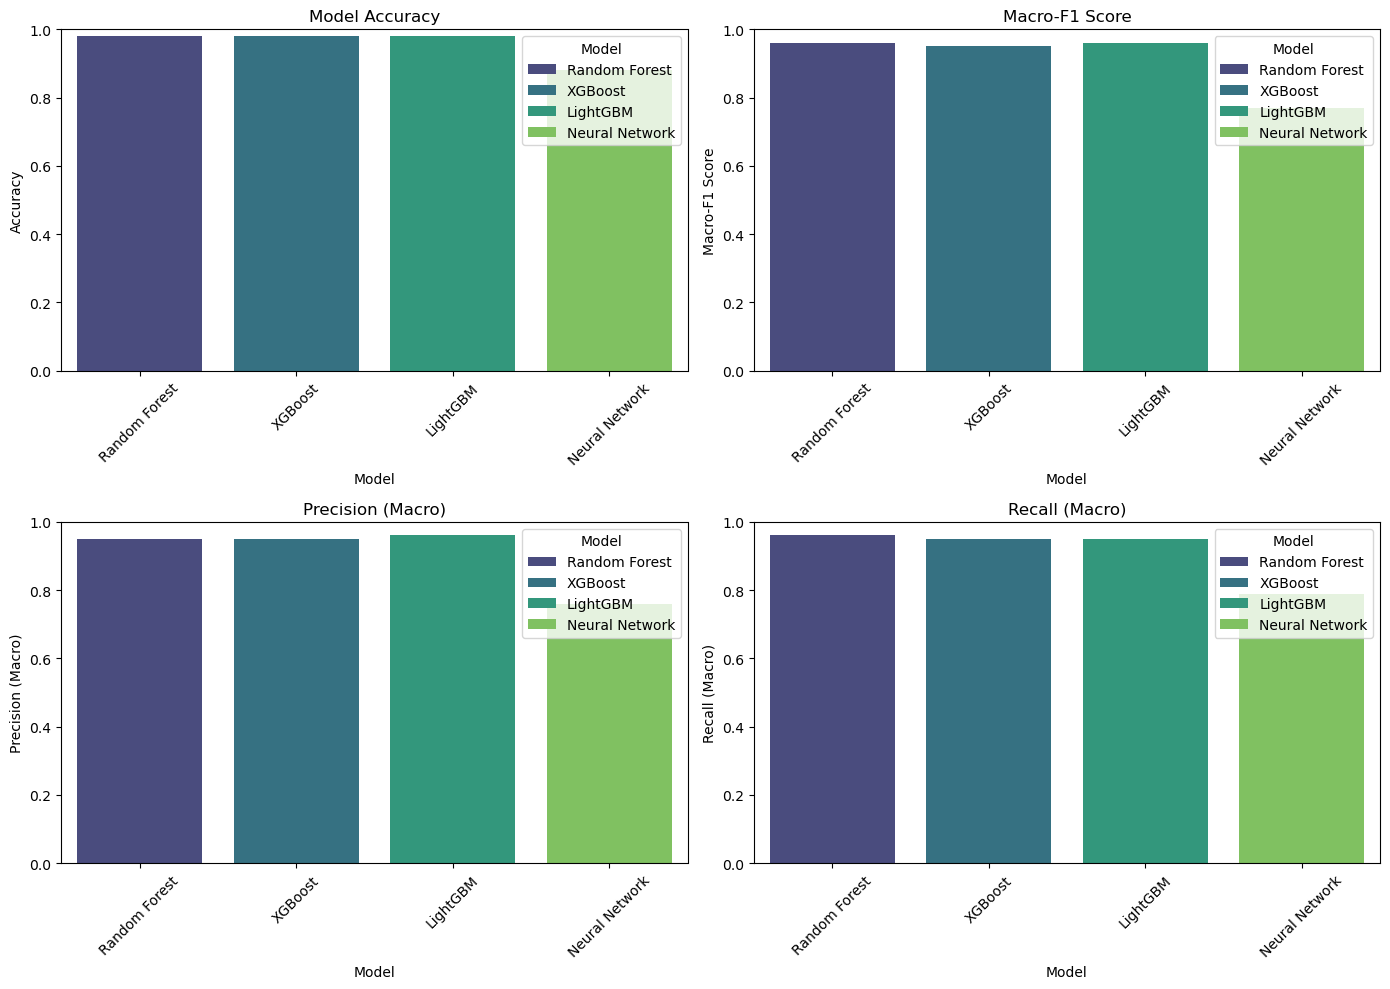

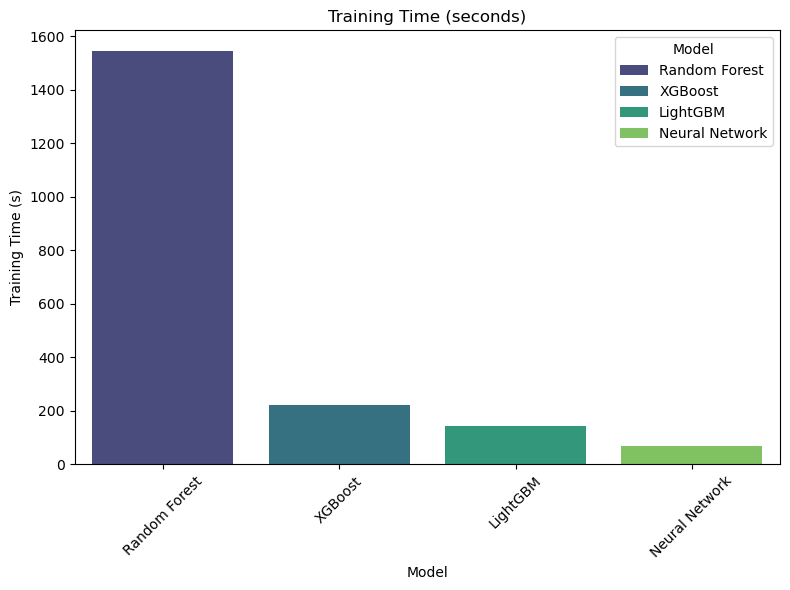

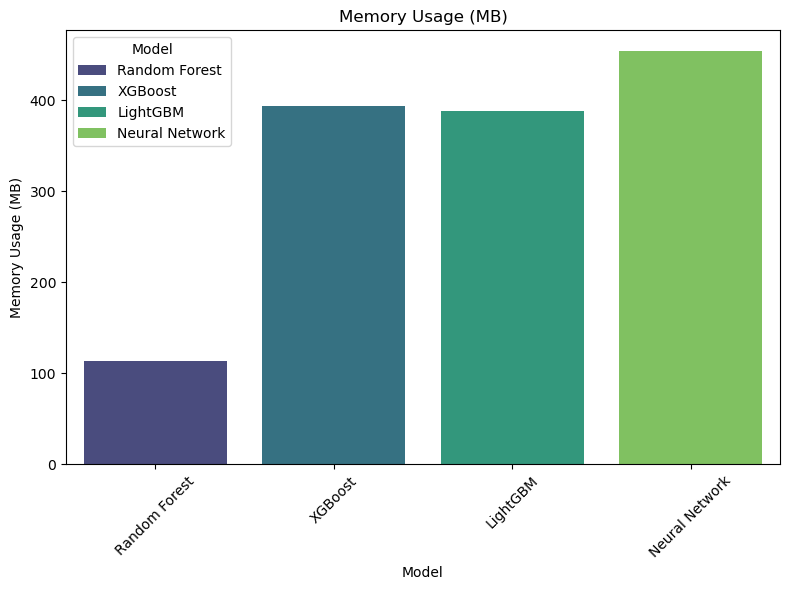

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data for comparison based on your provided outputs
data = {
    'Model': ['Random Forest', 'XGBoost', 'LightGBM', 'Neural Network'],
    'Accuracy': [0.98, 0.98, 0.98, 0.88],
    'Macro-F1 Score': [0.96, 0.95, 0.96, 0.77],
    'Precision (Macro)': [0.95, 0.95, 0.96, 0.76],
    'Recall (Macro)': [0.96, 0.95, 0.95, 0.79],
    'Training Time (s)': [1544.96, 220.16, 142.40, 69.31],
    'Memory Usage (MB)': [113.25, 393.50, 388.11, 453.97]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Print comparison table
print("Comparison Table:")
print(df.to_string(index=False))

# Find the best model based on Macro-F1 Score
best_model = df.loc[df['Macro-F1 Score'].idxmax()]

# Print the best model
print("\nBest Model Based on Macro-F1 Score:")
print(best_model)

# Set the figure size
plt.figure(figsize=(14, 10))

# Plot for Accuracy
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=df, palette='viridis', hue='Model', dodge=False)
plt.title('Model Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Plot for Macro-F1 Score
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='Macro-F1 Score', data=df, palette='viridis', hue='Model', dodge=False)
plt.title('Macro-F1 Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Plot for Precision (Macro)
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='Precision (Macro)', data=df, palette='viridis', hue='Model', dodge=False)
plt.title('Precision (Macro)')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Plot for Recall (Macro)
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='Recall (Macro)', data=df, palette='viridis', hue='Model', dodge=False)
plt.title('Recall (Macro)')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Improve layout
plt.tight_layout()
plt.show()

# Plot for Training Time
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Training Time (s)', data=df, palette='viridis', hue='Model', dodge=False)
plt.title('Training Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot for Memory Usage
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Memory Usage (MB)', data=df, palette='viridis', hue='Model', dodge=False)
plt.title('Memory Usage (MB)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from joblib import parallel_backend, dump
import time
import psutil
import os
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Load prepared data
X_train = pd.read_csv(r'D:/project4/Train_split.csv')
y_train = X_train.pop('IncidentGrade')
X_val = pd.read_csv(r'D:/project4/Valid_split.csv')
y_val = X_val.pop('IncidentGrade')

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Initialize Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Define a reduced parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 300, 500],  # Fewer estimators
    'max_depth': [None, 10, 20],  # Limited max depth options
    'max_features': ['sqrt', 'log2'],  # Removed None and fractions
    'min_samples_split': [2, 5],  # Reduced options
    'min_samples_leaf': [1, 2],  # Reduced options
    'bootstrap': [True, False]
}

# Setup randomized search with 3-fold cross-validation for faster evaluation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,  # Reduced iterations
    cv=cv,
    scoring='f1_macro',  # Use F1 score for evaluation
    n_jobs=-1,  # Use all available cores
    random_state=42
)

# Create pipeline with SMOTE and RandomizedSearchCV
pipeline = Pipeline([
    ('smote', smote),
    ('random_search', random_search)
])

# Train model with randomized search and time tracking using the full dataset
start_time = time.time()
with parallel_backend('loky'):
    pipeline.fit(X_train, y_train)  # Use the full dataset for training
end_time = time.time()

# Get memory usage
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 ** 2)  # Convert to MB

# Get the best model
best_rf = pipeline.named_steps['random_search'].best_estimator_

# Evaluate the model on the validation data
y_pred = best_rf.predict(X_val)

# Print results
print(f"Best Hyperparameters: {pipeline.named_steps['random_search'].best_params_}")
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print(f"Training Time: {end_time - start_time:.2f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")

# Save the best model as a .pkl file
dump(best_rf, r'D:/project4/best_random_forest_model.pkl')
print("Model saved as best_random_forest_model.pkl")


Best Hyperparameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1745
           1       0.91      0.91      0.91      1995
           2       0.99      0.97      0.98     13163

    accuracy                           0.96     16903
   macro avg       0.90      0.94      0.92     16903
weighted avg       0.96      0.96      0.96     16903

Confusion Matrix:
[[ 1614   106    25]
 [  135  1814    46]
 [  263    75 12825]]
Training Time: 928.46 seconds
Memory Usage: 592.28 MB
Model saved as best_random_forest_model.pkl


Calculating Random Forest Built-in Feature Importance...
Top 10 Important Features:
            Feature  Importance
2        IncidentId    0.227322
1             OrgId    0.180411
3           AlertId    0.107935
7   MitreTechniques    0.078286
0                Id    0.070318
8        EntityType    0.066298
5        AlertTitle    0.058290
31      LastVerdict    0.052783
4        DetectorId    0.043928
37        DayOfWeek    0.037589


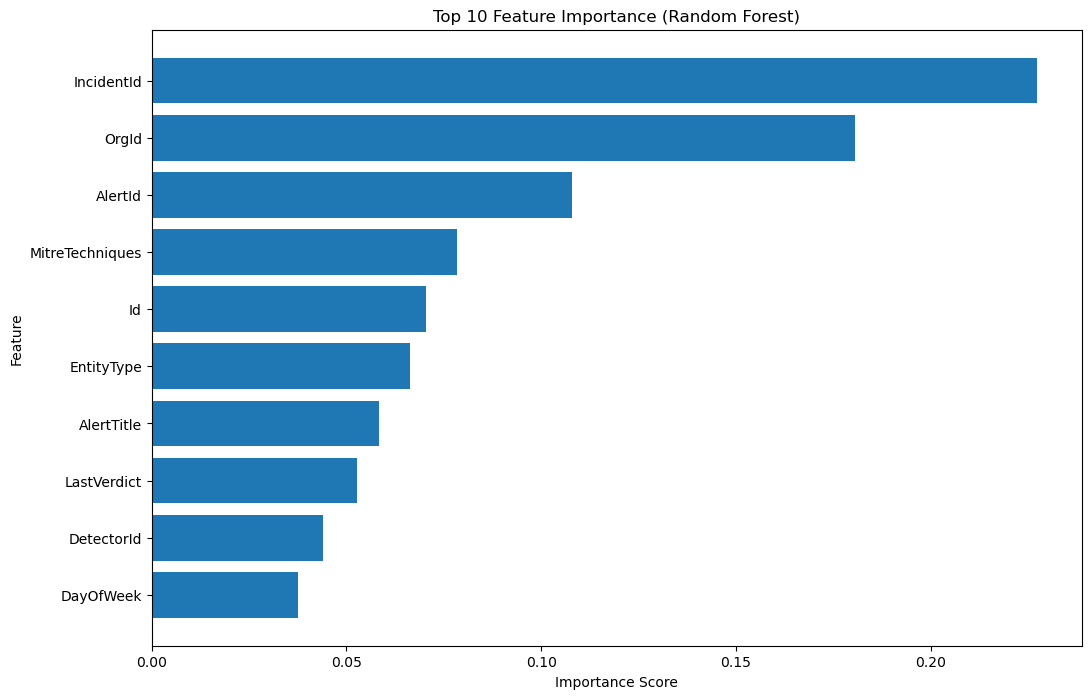

Number of misclassifications: 650
Sample misclassified cases:
       Id  OrgId  IncidentId  AlertId  DetectorId  AlertTitle  Category  \
47   3570    247       37784   216694           1    0.360208         6   
65     81     67      180627   242825          10    0.369311         6   
105  3529    136      177775  1319621           7    0.366710         6   
117   675    308       34430   183846           0    0.358908         6   
124  1030     56      114593    94740           1    0.360208         6   

     MitreTechniques  EntityType  EvidenceRole  ...  OSFamily  OSVersion  \
47                29           6             1  ...       0.0        0.0   
65                28           6             1  ...       0.0        0.0   
105               23           0             1  ...       0.0        0.0   
117               23           0             1  ...       0.0        0.0   
124               29           6             1  ...       0.0        0.0   

     LastVerdict  CountryCode 

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from joblib import load

# Load prepared data
X_train = pd.read_csv(r'D:/project4/Train_split.csv')
y_train = X_train.pop('IncidentGrade')
X_val = pd.read_csv(r'D:/project4/Valid_split.csv')
y_val = X_val.pop('IncidentGrade')

# Load the trained Random Forest model
best_rf = load(r'D:/project4/best_random_forest_model.pkl')

# Calculate feature importance
print("Calculating Random Forest Built-in Feature Importance...")
feature_importances = best_rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_val.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display top 10 important features
print("Top 10 Important Features:")
print(feature_importance_df.head(10))

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])
plt.title('Top 10 Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

# Make predictions
y_pred = best_rf.predict(X_val)

# Error Analysis
misclassified_indices = np.where(y_pred != y_val)[0]
num_misclassified = len(misclassified_indices)
print(f"Number of misclassifications: {num_misclassified}")

# Display sample of misclassified cases
print("Sample misclassified cases:")
print(X_val.iloc[misclassified_indices].head())

# Evaluate the model's predictions
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

In [31]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from joblib import load
import time
import psutil
import os

# Load the saved model
best_model_path = r'D:/project4/best_random_forest_model.pkl'
loaded_model = load(best_model_path)

# Load the test dataset
test_file_path = r'D:/project4/Testing_data.csv'
df_test = pd.read_csv(test_file_path)

# Prepare test data
X_test = df_test.drop(columns=['IncidentGrade'])
y_test = df_test['IncidentGrade']

# Start time for evaluating the model
start_time = time.time()

# Make predictions using the loaded model
y_test_pred = loaded_model.predict(X_test)

# End time for evaluating the model
end_time = time.time()

# Calculate memory usage
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 ** 2)  # Convert to MB

# Calculate and print the evaluation metrics
print("Test Set Results:")
print(f"Macro-F1 Score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"Macro Precision: {precision_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"Macro Recall: {recall_score(y_test, y_test_pred, average='macro'):.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_test_pred))

# Print training time and memory usage
print(f"Evaluation Time: {end_time - start_time:.2f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")

Test Set Results:
Macro-F1 Score: 0.8751
Macro Precision: 0.8497
Macro Recall: 0.9132

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.68      0.93      0.79     36643
           1       0.87      0.86      0.86     42156
           2       0.99      0.96      0.97    313840

    accuracy                           0.94    392639
   macro avg       0.85      0.91      0.88    392639
weighted avg       0.95      0.94      0.95    392639

Confusion Matrix (Test Set):
[[ 34015   2219    409]
 [  4910  36086   1160]
 [ 10850   3133 299857]]
Evaluation Time: 40.31 seconds
Memory Usage: 618.74 MB


In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import time
import psutil
import os

# Load the test dataset
test_file_path = r'D:/project4/Testing_data.csv'
df_test = pd.read_csv(test_file_path)

# Prepare features and target variable
X_test = df_test.drop(columns=['IncidentGrade'])
y_test = df_test['IncidentGrade']

# Initialize logistic regression with default parameters
logreg = LogisticRegression(max_iter=100, solver='liblinear')

# Train-validation split with stratification
# Split the data again for training and validation since it's mentioned as 'Test Dataset'
X_train, X_val, y_train, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42, stratify=y_test)

# Train model with time tracking
start_time = time.time()
logreg.fit(X_train, y_train)
end_time = time.time()

# Get memory usage
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 ** 2)  # Convert to MB

# Evaluate the model on validation data (using the test split as validation here)
y_val_pred = logreg.predict(X_val)

# Print validation results
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print(f"Training Time: {end_time - start_time:.2f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")

# Calculate and print the evaluation metrics for the validation set
print("\nValidation Set Results:")
print(f"Macro-F1 Score: {f1_score(y_val, y_val_pred, average='macro'):.4f}")
print(f"Macro Precision: {precision_score(y_val, y_val_pred, average='macro'):.4f}")
print(f"Macro Recall: {recall_score(y_val, y_val_pred, average='macro'):.4f}")

# Evaluate the model on the entire test data (use this if you want to evaluate on the full test set)
y_test_pred = logreg.predict(X_test)

# Calculate and print the evaluation metrics for the test set
print("\nTest Set Results:")
print(f"Macro-F1 Score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"Macro Precision: {precision_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"Macro Recall: {recall_score(y_test, y_test_pred, average='macro'):.4f}")

print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Test Set Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.34      0.41      7329
           1       0.73      0.58      0.64      8431
           2       0.90      0.96      0.93     62768

    accuracy                           0.86     78528
   macro avg       0.72      0.63      0.66     78528
weighted avg       0.85      0.86      0.85     78528

Validation Confusion Matrix:
[[ 2463  1026  3840]
 [  649  4859  2923]
 [ 1556   788 60424]]
Training Time: 103.06 seconds
Memory Usage: 13.97 MB

Validation Set Results:
Macro-F1 Score: 0.6613
Macro Precision: 0.7184
Macro Recall: 0.6250

Test Set Results:
Macro-F1 Score: 0.6588
Macro Precision: 0.7161
Macro Recall: 0.6225

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.34      0.41     36643
           1       0.72      0.57      0.64     42156
           2       0.90      0.96      0.93    313840

    accu

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import time
import psutil
import os
import numpy as np

# Load the test dataset
test_file_path = r'D:/project4/Testing_data.csv'
df_test = pd.read_csv(test_file_path)

# Prepare features and target variable
X_test = df_test.drop(columns=['IncidentGrade'])
y_test = df_test['IncidentGrade']

# Train-validation split with stratification
X_train, X_val, y_train, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42, stratify=y_test)

# Initialize decision tree classifier
decision_tree = DecisionTreeClassifier(random_state=42)

# Define the parameter grid for GridSearchCV (reduced search space)
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 5],
    'ccp_alpha': np.linspace(0, 0.01, 5)  # Reduced range for pruning parameter
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=decision_tree,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Train model with time tracking
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

# Get the best model
best_decision_tree = grid_search.best_estimator_

# Get memory usage
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 ** 2)  # Convert to MB

# Evaluate the best model on validation data
y_val_pred = best_decision_tree.predict(X_val)

# Print validation results
print("Best Parameters:")
print(grid_search.best_params_)
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print(f"Training Time: {end_time - start_time:.2f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")

# Evaluate the best model on the entire test data
y_test_pred = best_decision_tree.predict(X_test)

# Calculate and print the evaluation metrics for the test set
print("\nTest Set Results:")
print(f"Macro-F1 Score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"Macro Precision: {precision_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"Macro Recall: {recall_score(y_test, y_test_pred, average='macro'):.4f}")

print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Test Set Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best Parameters:
{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      7329
           1       0.93      0.93      0.93      8431
           2       0.99      0.99      0.99     62768

    accuracy                           0.97     78528
   macro avg       0.93      0.94      0.94     78528
weighted avg       0.97      0.97      0.97     78528

Validation Confusion Matrix:
[[ 6693   328   308]
 [  348  7841   242]
 [  654   237 61877]]
Training Time: 400.15 seconds
Memory Usage: 129.27 MB

Test Set Results:
Macro-F1 Score: 0.9424
Macro Precision: 0.9367
Macro Recall: 0.9485

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     36643
           1       0.94 

Comparison of Model Performance:
                 Model  Accuracy  Macro Avg Precision  Macro Avg Recall  \
0        Random Forest      0.94                 0.85              0.91   
1  Logistic Regression      0.86                 0.72              0.62   
2        Decision Tree      0.98                 0.94              0.95   

   Macro Avg F1-Score  Weighted Avg Precision  Weighted Avg Recall  \
0                0.86                    0.95                 0.94   
1                0.66                    0.85                 0.86   
2                0.94                    0.98                 0.98   

   Weighted Avg F1-Score  Training Time (s)  Memory Usage (MB)  \
0                   0.95              40.31             618.74   
1                   0.85              44.22             414.65   
2                   0.98             400.15             129.27   

   Time per Accuracy (s)  Memory per Accuracy (MB)  
0              42.882979                658.234043  
1             

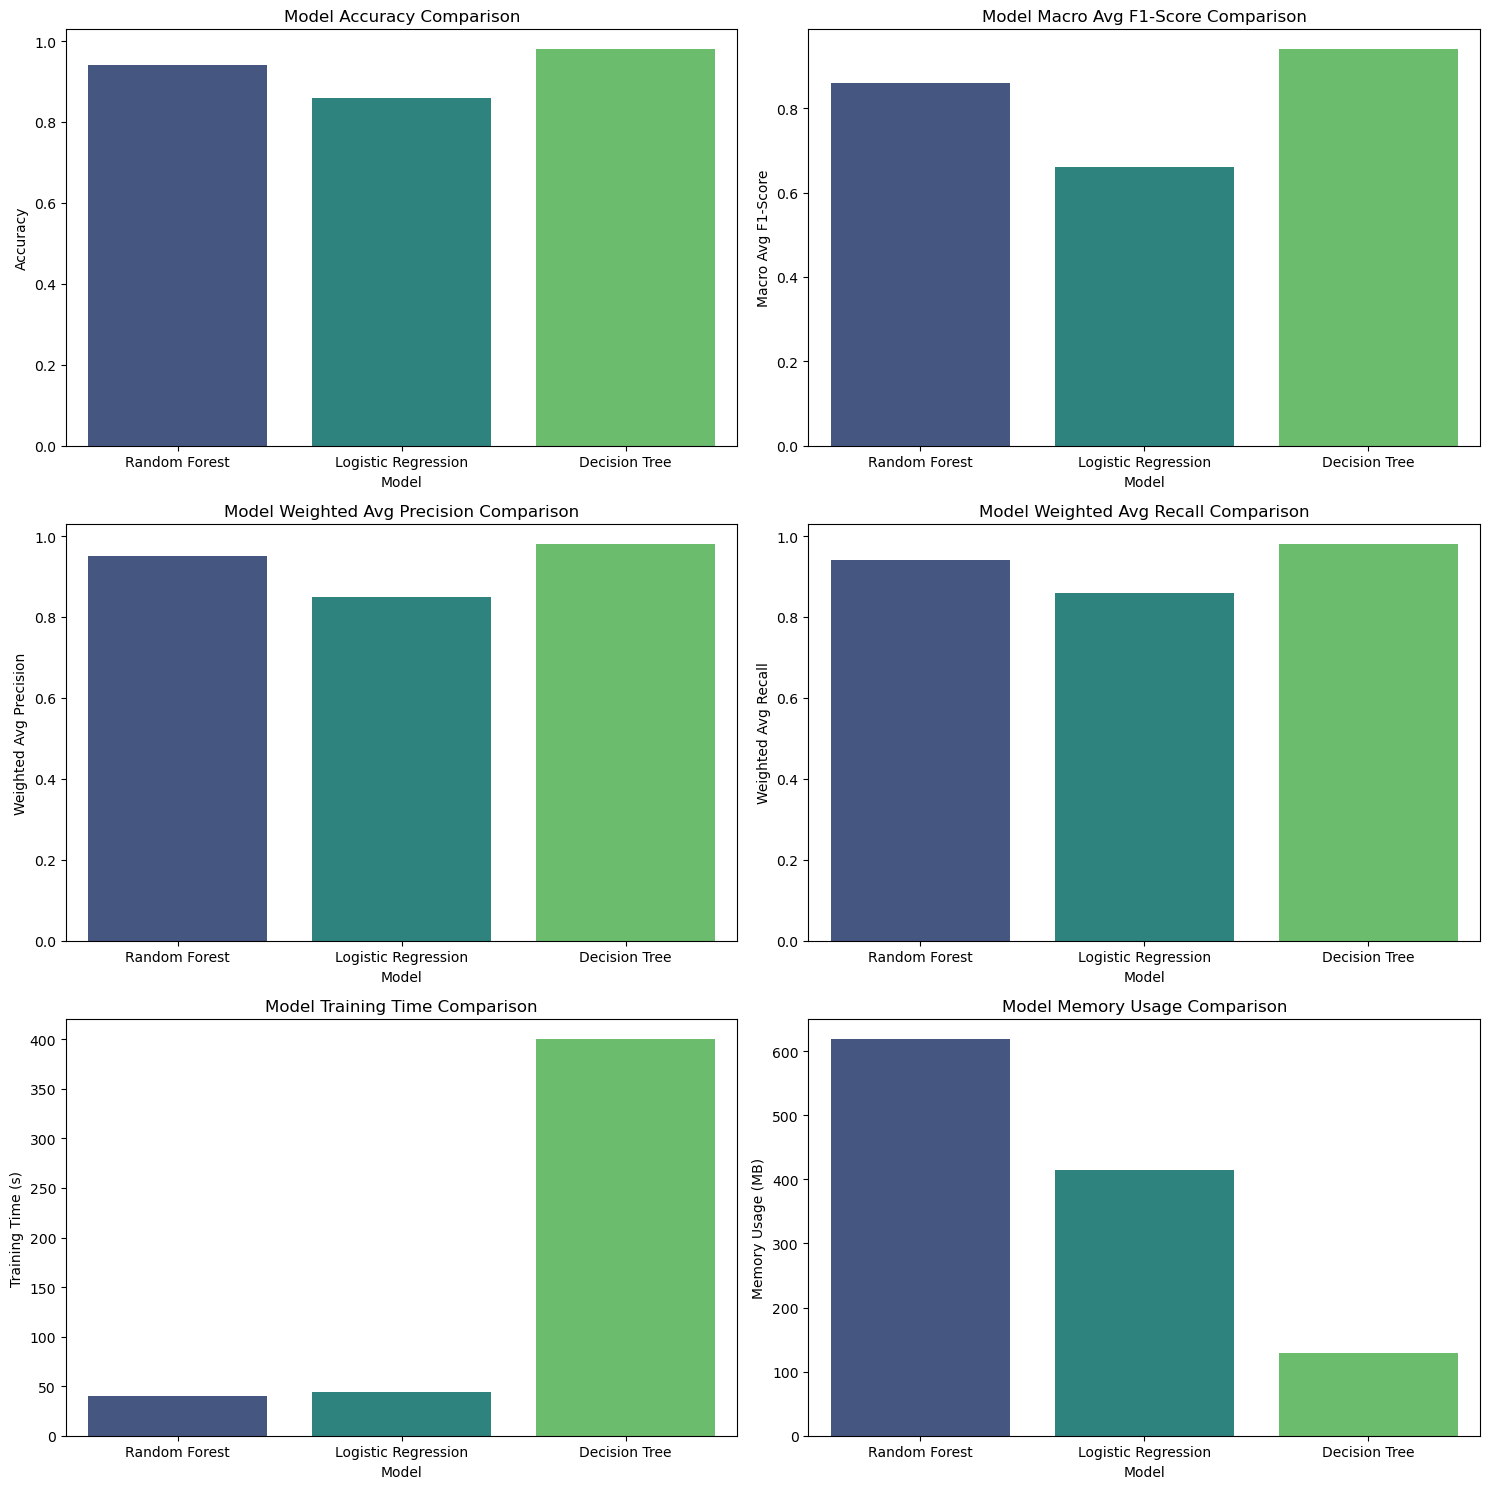

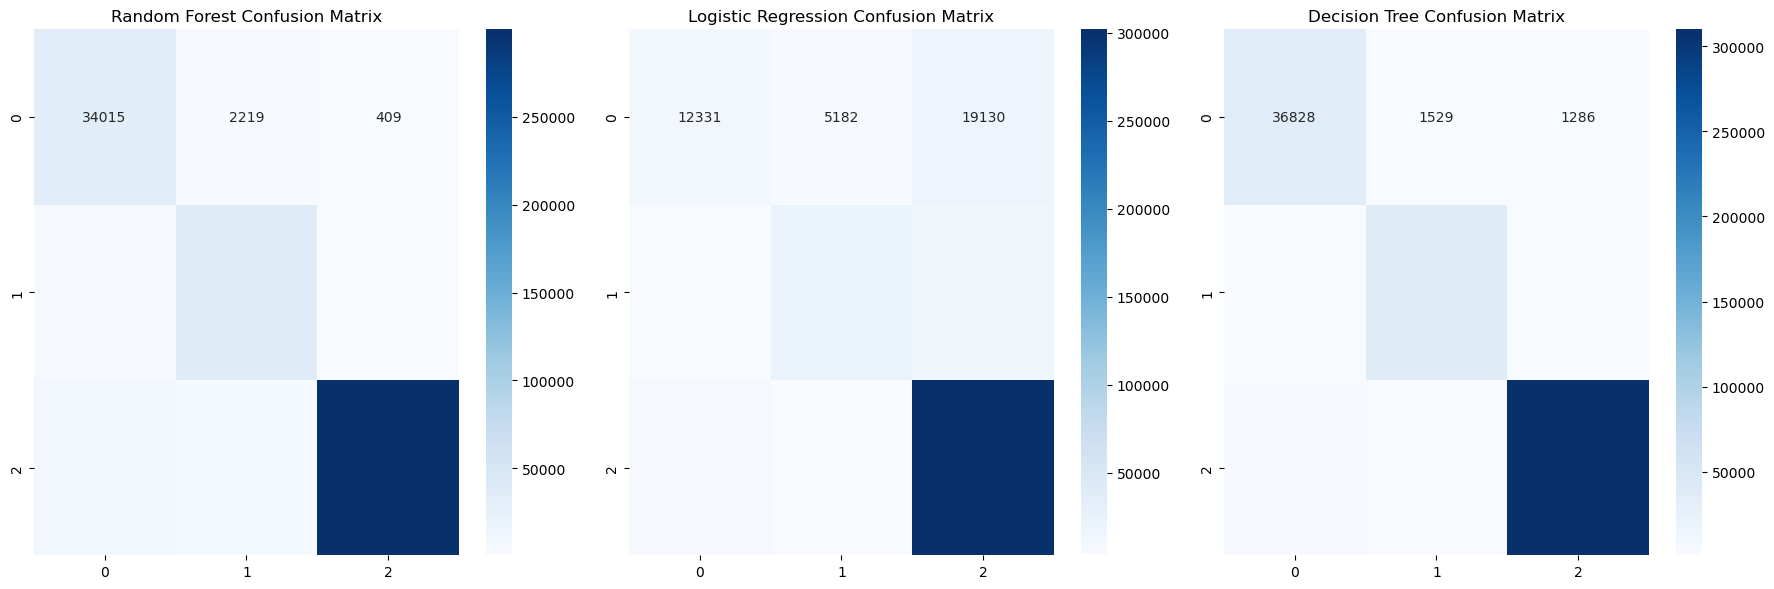

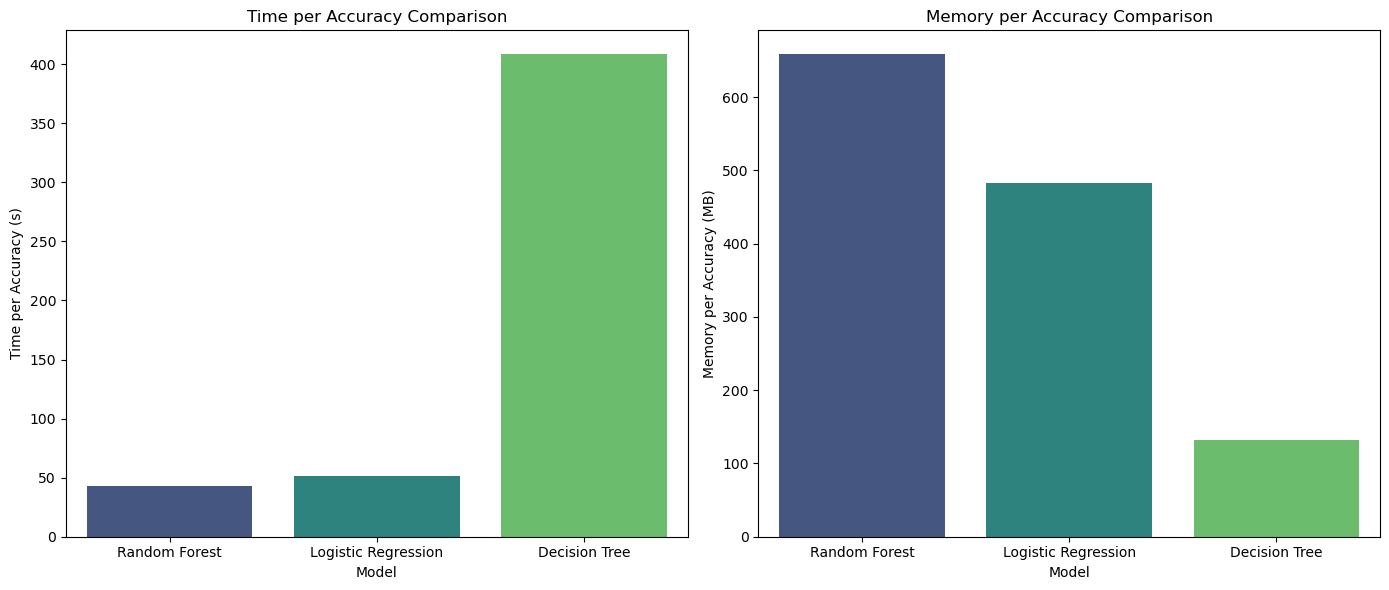

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Random Forest results as dictionaries
random_forest_report = {
    "accuracy": 0.94,
    "macro avg": {"precision": 0.85, "recall": 0.91, "f1-score": 0.86},
    "weighted avg": {"precision": 0.95, "recall": 0.94, "f1-score": 0.95},
    "Training Time (s)": 40.31,
    "Memory Usage (MB)": 618.74,
    "Confusion Matrix": np.array([[34015, 2219, 409], [4910, 36086, 1160], [10850, 3133, 299857]])
}

# Logistic Regression results as dictionaries
logistic_regression_report = {
    "accuracy": 0.86,
    "macro avg": {"precision": 0.72, "recall": 0.62, "f1-score": 0.66},
    "weighted avg": {"precision": 0.85, "recall": 0.86, "f1-score": 0.85},
    "Training Time (s)": 44.22,
    "Memory Usage (MB)": 414.65,
    "Confusion Matrix": np.array([[12331, 5182, 19130], [3235, 23975, 14946], [7753, 4095, 301992]])
}

# Decision Tree results as dictionaries
decision_tree_report = {
    "accuracy": 0.98,
    "macro avg": {"precision": 0.94, "recall": 0.95, "f1-score": 0.94},
    "weighted avg": {"precision": 0.98, "recall": 0.98, "f1-score": 0.98},
    "Training Time (s)": 400.15,
    "Memory Usage (MB)": 129.27,
    "Confusion Matrix": np.array([[36828, 1529, 1286], [1679, 39424, 1053], [2979, 1045, 309816]])
}

# Creating a DataFrame for better visualization
data = {
    "Model": ["Random Forest", "Logistic Regression", "Decision Tree"],
    "Accuracy": [random_forest_report["accuracy"], logistic_regression_report["accuracy"], decision_tree_report["accuracy"]],
    "Macro Avg Precision": [random_forest_report["macro avg"]["precision"], logistic_regression_report["macro avg"]["precision"], decision_tree_report["macro avg"]["precision"]],
    "Macro Avg Recall": [random_forest_report["macro avg"]["recall"], logistic_regression_report["macro avg"]["recall"], decision_tree_report["macro avg"]["recall"]],
    "Macro Avg F1-Score": [random_forest_report["macro avg"]["f1-score"], logistic_regression_report["macro avg"]["f1-score"], decision_tree_report["macro avg"]["f1-score"]],
    "Weighted Avg Precision": [random_forest_report["weighted avg"]["precision"], logistic_regression_report["weighted avg"]["precision"], decision_tree_report["weighted avg"]["precision"]],
    "Weighted Avg Recall": [random_forest_report["weighted avg"]["recall"], logistic_regression_report["weighted avg"]["recall"], decision_tree_report["weighted avg"]["recall"]],
    "Weighted Avg F1-Score": [random_forest_report["weighted avg"]["f1-score"], logistic_regression_report["weighted avg"]["f1-score"], decision_tree_report["weighted avg"]["f1-score"]],
    "Training Time (s)": [random_forest_report["Training Time (s)"], logistic_regression_report["Training Time (s)"], decision_tree_report["Training Time (s)"]],
    "Memory Usage (MB)": [random_forest_report["Memory Usage (MB)"], logistic_regression_report["Memory Usage (MB)"], decision_tree_report["Memory Usage (MB)"]],
    "Time per Accuracy (s)": [random_forest_report["Training Time (s)"]/random_forest_report["accuracy"], logistic_regression_report["Training Time (s)"]/logistic_regression_report["accuracy"], decision_tree_report["Training Time (s)"]/decision_tree_report["accuracy"]],
    "Memory per Accuracy (MB)": [random_forest_report["Memory Usage (MB)"]/random_forest_report["accuracy"], logistic_regression_report["Memory Usage (MB)"]/logistic_regression_report["accuracy"], decision_tree_report["Memory Usage (MB)"]/decision_tree_report["accuracy"]]
}

df = pd.DataFrame(data)

# Print the DataFrame to compare
print("Comparison of Model Performance:")
print(df)

# Visualization using matplotlib and seaborn

# Create subplots for each metric category
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Accuracy
sns.barplot(x='Model', y='Accuracy', data=df, ax=axes[0, 0], palette="viridis")
axes[0, 0].set_title('Model Accuracy Comparison')

# Macro Avg F1-Score
sns.barplot(x='Model', y='Macro Avg F1-Score', data=df, ax=axes[0, 1], palette="viridis")
axes[0, 1].set_title('Model Macro Avg F1-Score Comparison')

# Weighted Avg Precision
sns.barplot(x='Model', y='Weighted Avg Precision', data=df, ax=axes[1, 0], palette="viridis")
axes[1, 0].set_title('Model Weighted Avg Precision Comparison')

# Weighted Avg Recall
sns.barplot(x='Model', y='Weighted Avg Recall', data=df, ax=axes[1, 1], palette="viridis")
axes[1, 1].set_title('Model Weighted Avg Recall Comparison')

# Training Time
sns.barplot(x='Model', y='Training Time (s)', data=df, ax=axes[2, 0], palette="viridis")
axes[2, 0].set_title('Model Training Time Comparison')

# Memory Usage
sns.barplot(x='Model', y='Memory Usage (MB)', data=df, ax=axes[2, 1], palette="viridis")
axes[2, 1].set_title('Model Memory Usage Comparison')

plt.tight_layout()
plt.show()

# Confusion Matrix Heatmaps
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(random_forest_report["Confusion Matrix"], annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Random Forest Confusion Matrix')

sns.heatmap(logistic_regression_report["Confusion Matrix"], annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Logistic Regression Confusion Matrix')

sns.heatmap(decision_tree_report["Confusion Matrix"], annot=True, fmt='d', cmap='Blues', ax=ax[2])
ax[2].set_title('Decision Tree Confusion Matrix')

plt.tight_layout()
plt.show()

# Additional Comparison of Time and Memory per Accuracy
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x='Model', y='Time per Accuracy (s)', data=df, ax=axes[0], palette="viridis")
axes[0].set_title('Time per Accuracy Comparison')

sns.barplot(x='Model', y='Memory per Accuracy (MB)', data=df, ax=axes[1], palette="viridis")
axes[1].set_title('Memory per Accuracy Comparison')

plt.tight_layout()
plt.show()